This notebook includes many simulation to study many statisitcal problems

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from joblib import Parallel, delayed

In [5]:
rng = np.random.RandomState(8888)

In [7]:
n = 100
true_y = rng.normal(size=n,loc = 0,scale=3)
np.var(true_y)

8.862893068247667

In [15]:
temp = rng.normal(size = (100,5),loc = 5)
temp.sum(axis=0)

array([492.24610295, 502.85358726, 472.59419786, 494.11218604,
       506.62247862])

#### normalize so that columns sum to 1

In [16]:
temp_norm = temp/temp.sum(axis=0)
temp_norm.sum(axis=0)

array([1., 1., 1., 1., 1.])

#### normalize so that rows sum to 1

In [18]:
temp_norm_row = (temp.T / temp.sum(axis=1)).T
temp_norm_row.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### distinct, NA

In [19]:
df = pd.DataFrame({"x":[1,np.nan,3,5],'y':[2,5,1,3]})

In [21]:
df.isnull().sum(axis=0)

x    1
y    0
dtype: int64

In [26]:
df.nunique()

x    3
y    4
dtype: int64

#### np not na index

In [3]:
x = np.array([1,3,np.nan,5])
x[~np.isnan(x)]

array([1., 3., 5.])

Samples are correlated (some user's measurement were taken multiple times), bootstrap can correct it (assuming `true_y` is I.I.D)

__Recall from A/B Testing books: Having the randomization unit be coarser than the analysis uniut, such as randomizing by user and the click-through rate (by page) , will work, but requires more nuanced anlayses methods such as bootstrap or the delta method__.

- Bootstrap: We can sample 1 from each user_id (each user_id might mulitple page views) and estimate variance this way. Or later Bootstrap T method discussed later

- Delta method: Directly brute force calculation of variance on the user metrics. (see book)
- CUPED and other variance reduction techniques


In [8]:
n_replicates = 1000
out = rng.choice(true_y,size=(n_replicates,n))

In [9]:
np.mean(out.var(axis=1))

8.834754276635184

__Outlier effect on A/B testing, p-value of 0.32 and T-stat of 1.__

https://statisticaloddsandends.wordpress.com/2020/10/01/p-value-around-0-32-you-may-have-a-problem-with-outliers/

In [16]:
n = 100
a = rng.uniform(size = n)
b = rng.uniform(size = n)
stats.ttest_1samp(a,popmean= 1/2 )

Ttest_1sampResult(statistic=0.6196367030219052, pvalue=0.5369205035631737)

#### still same conclusion (insignificant) due to cancellation of the outlier in both numerator and denominator

Assume paired test

In [17]:
a[-1] = 10000
stats.ttest_1samp(a,popmean=1/2)

Ttest_1sampResult(statistic=1.0002202132496276, pvalue=0.31964245147070597)

In [18]:
stats.ttest_1samp(a-b,popmean=0)

Ttest_1sampResult(statistic=1.0004333959253777, pvalue=0.31953983594756175)

In [19]:
stats.ttest_rel(a,b)

Ttest_relResult(statistic=1.0004333959253777, pvalue=0.31953983594756175)

Assume independent two sample test

In [19]:
stats.ttest_ind(a,b)

Ttest_indResult(statistic=0.9995821663324865, pvalue=0.31873277752641305)

In [20]:
stats.ttest_ind(a,b,permutations = 1000)

Ttest_indResult(statistic=0.9995821663324865, pvalue=0.87)

__T-stats__

In [13]:
a.mean()/(a.std()/np.sqrt(n))

1.0102845891186012

### prop test (same P-value as chis-squared test)
$ Z^2 = \chi^2_1$

$H_0: p_1 - p_2$ =0

$H_1: Not Equal $

In [95]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([14, 20])
nobs = np.array([100, 100])
stat, pval = proportions_ztest(count, nobs)
stat, pval

(-1.129464917246783, 0.25870176105718956)

In [94]:
from scipy.stats import norm
pooled = count.sum()/nobs.sum()
stat_by_hand = (0.14 - 0.2) / np.sqrt(2 * pooled * (1-pooled)/nobs[0])
stat_by_hand, 2 * norm.cdf(stat_by_hand)

(-1.1294649172467832, 0.25870176105718945)

__Chi-squared contingency test for independence__

In [509]:
contingency_table = np.array([14,86,20,80]).reshape(2,2)
contingency_table

array([[14, 86],
       [20, 80]])

In [500]:
exp_table = np.array([100*34/200,100*166/200,100*34/200,100*166/200]).reshape(2,2)
exp_table

array([[17., 83.],
       [17., 83.]])

In [502]:
chi_stat = ((contingency_table - exp_table) ** 2 / exp_table).reshape(-1).sum()

In [504]:
from scipy.stats import chi2

1 - chi2.cdf(chi_stat,df = 1)

0.25870176105718934

## Permutation test

Non-parametric test when the normality of tests do not hold

In [65]:
n = 100
treat_effect = 0.3
control = 1 + np.random.normal(size = n)
treatment = 1 + np.random.normal(size = n) + treat_effect

In [66]:
stats.ttest_ind(control,treatment)

Ttest_indResult(statistic=-2.817861558598173, pvalue=0.005324791945203552)

In [67]:
stats.ttest_ind(control,treatment,permutations = 10000)

Ttest_indResult(statistic=-2.817861558598173, pvalue=0.0041)

## Fisher’s Exact Test

Test for contingency table when sample size is small (or large), in particular, the P-value can be calculated exactly, rather than relying on an approximation that becomes exact in the limit as the sample size grows to infinity, as with many statistical tests. https://en.wikipedia.org/wiki/Fisher%27s_exact_test

The question we ask about these data is: Knowing that 10 of these 24 teenagers are studying and that 12 of the 24 are female, and assuming the null hypothesis that men and women are equally likely to study, what is the probability that these 10 teenagers who are studying would be so unevenly distributed between the women and the men? If we were to choose 10 of the teenagers at random, what is the probability that 9 or more of them would be among the 12 women and only 1 or fewer from among the 12 men?

||Men|Women|
|--|--|--|
|Study|1|9|
|Non Study|11|3|

#### less and greater based on table ordering

In [480]:
from scipy.stats import fisher_exact
fisher_exact(table=[[1,9],[11,3]], alternative="less")

SignificanceResult(statistic=0.030303030303030304, pvalue=0.0013797280926100418)

In [482]:
fisher_exact(table=[[9,1],[3,11]], alternative="greater")

SignificanceResult(statistic=33.0, pvalue=0.0013797280926100418)

## Bootstrap with parallel

### non-parametric bootstrap

In [3]:
from joblib import Parallel, delayed # for parallel processing
import numpy as np
x = np.random.normal(size = 100, scale =10)
bootstrap_samples = 100
def std_sample(x):
    x = np.random.choice(x,size = len(x),replace = True)
    return(x.std())
out = Parallel(n_jobs = 10)(delayed(std_sample)(x) for _ in range(bootstrap_samples))

np.quantile(out,[0.025,0.5,0.975])

array([ 7.83456167,  8.84695193, 10.07557688])

In [6]:
from joblib import delayed, Parallel
import scipy.stats as ss
import numpy as np

In [61]:
np.random.seed(8888)
x = ss.cauchy.rvs(size = 100)
n_boot_samples = 5000
def var_sample(x):
    x_boot = np.random.choice(x, size = len(x), replace = True)
    return np.median(x_boot)

In [62]:
boot_median = Parallel(n_jobs = 10)(delayed(var_sample)(x) for _ in range(n_boot_samples))
np.var(boot_median)

0.024537052995451843

### Check the lecture notes on bootstrap for math detail

### Parametric bootstrap

Use sample statistic and assumes a parametric distribution.

Example: Use the sample median and assummes true population is a Cauchy, do bootstrap and construct interval

In [63]:
np.random.seed(8888)
x = ss.cauchy.rvs(size = 100)
n_boot_samples = 5000
sample_median = np.median(x)
def var_sample(x0):
    x_par = ss.cauchy.rvs(size = 100,loc = x0)
    return np.median(x_par)

In [64]:
para_bootstrap = Parallel(n_jobs = 10)(delayed(var_sample)(sample_median) for _ in range(n_boot_samples))
np.var(para_bootstrap)

0.02447355007653579

### Non parametric Bootstrap percentile vs. T-method

In [20]:
rng = np.random.RandomState(0)
n = 500
p = 1
x = rng.normal(size=(n,p))
beta = [1,5]
y = np.dot(np.concatenate((np.repeat(1,n)[:,None],x),axis=1),beta) + rng.normal(size =n)

In [21]:
import pandas as pd
data = pd.DataFrame(np.concatenate((y[:,None],x),axis=1),columns = ["y",'x'])
              

#### percentile CI method

In [22]:
## percentile CI method
import statsmodels.formula.api as smf
n_boot = 1000
def get_ratio_boot(data):
    coef = smf.ols("y~x",data = data).fit().params
    return coef[1]/coef[0]

out = Parallel(n_jobs = 10)(delayed(get_ratio_boot)(data.sample(frac = 1, replace = True)) for _ in range(n_boot))

In [23]:
np.quantile(out,[0.025,0.975])

array([4.85929696, 5.82460528])

#### T method

In [24]:
import statsmodels.formula.api as smf
n_boot = 1000
model = smf.ols("y~x",data = data).fit()
model_coef = model.params
coef_cov = model.cov_params()
theta_hat = model_coef[1] / model_coef[0]
sigma2_delta = theta_hat**2 * (coef_cov.iloc[1,1]/(model_coef[1]**2)  + coef_cov.iloc[0,0]/(model_coef[0]**2) - 2 * (coef_cov.iloc[1,0])/ (model_coef[0] * model_coef[1]))

def get_ratio_boot(data,theta_hat):
    model = smf.ols("y~x",data = data).fit()
    coef = model.params
    coef_cov = model.cov_params()
    theta_hat_boot =  coef[1]/coef[0]
    sigma2_delta = theta_hat_boot**2 * (coef_cov.iloc[1,1]/(coef[1]**2)  + coef_cov.iloc[0,0]/(coef[0]**2) - 2 * (coef_cov.iloc[1,0])/ (coef[0] * coef[1]))
    return ((theta_hat_boot-theta_hat) / np.sqrt(sigma2_delta))

out = Parallel(n_jobs = 10)(delayed(get_ratio_boot)(data.sample(frac = 1, replace = True), theta_hat) for _ in range(n_boot))

In [26]:
t_quant = np.quantile(out,[0.025,0.975])
theta_hat + t_quant * np.sqrt(sigma2_delta)

array([4.76660753, 5.76852671])

## Given U(0,1), sample discrete distribution (a,b)

<AxesSubplot:ylabel='Count'>

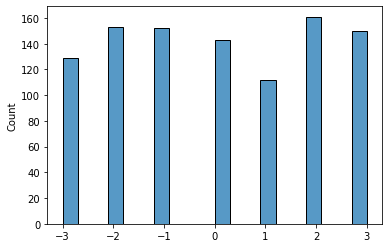

In [130]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def map_u_to_discrete(a,b,n=1000):
    x = np.random.uniform(size = n)
    y = np.linspace(a,b,b-a+1)
    buckets = np.linspace(0,1,b-a+2)[1:] ## same as below question
    return [y[np.where(x_i<=buckets)[0][0]] for x_i in x]
out = map_u_to_discrete(-3,3)
sns.histplot(out,bins=20)

## Given U(0,1) generate binomial(n = 4, p =5/8)

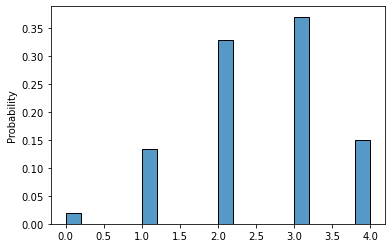

In [11]:
from scipy.stats import binom

p = binom.cdf(k= np.linspace(0,4,5),n=4,p=5/8)
x = np.random.uniform(size = 10000)
y_samples = [np.where(x_i <= p)[0][0] for x_i in x]
sns.histplot(y_samples,bins=20, stat = 'probability');

In [10]:
binom.pmf(k= np.linspace(0,4,5),n=4,p=5/8)

array([0.01977539, 0.13183594, 0.32958984, 0.36621094, 0.15258789])

In [124]:
p

array([0.01977539, 0.15161133, 0.48120117, 0.84741211, 1.        ])

## OLS R style formula trick 

In [20]:
import statsmodels.formula.api as smf
feature_name = ['x1','x2','x3']
formula = "y~"+"+".join(feature_name)
print(formula)
#model = smf.ols(formula,data = data).fit()

y~x1+x2+x3


## Sequential probability ratio test 
https://en.wikipedia.org/wiki/Sequential_probability_ratio_test
https://towardsdatascience.com/experiments-peeking-and-optimal-stopping-954506cec665

$H_0 = \theta_0$

$H_1 = \theta_1$ 

where $\theta_1 > \theta_0$

Likelihood ratio is taken by $ \frac{L(\theta_1)}{L(\theta_0)}$

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.stats import expon
import matplotlib.pyplot as plt

In [4]:
def SLRT(alpha = 0.05, beta = 0.2, true_diff = 0.1, theta_alt = 0.1, total_n = 1000, n_stream = 1):
    a = np.log( beta / (1-alpha) )
    b = np.log( (1-beta) / alpha )
    Y = np.array([])
    LR = np.repeat(0.0,int(total_n/n_stream))
    decision = np.nan
    for idx, i in enumerate(range(0,total_n,n_stream)):
        y_new = norm.rvs(loc=true_diff,scale=1,size=n_stream)
        Y = np.concatenate((Y,y_new))
        LR[idx] = norm.logpdf(y_new,loc=theta_alt,scale=1).sum() - norm.logpdf(y_new,loc=0,scale=1).sum()
        if sum(LR) < a:
            decision = 0
            break
        elif sum(LR) > b:
            decision = 1
            break 
    plt.plot(np.cumsum(LR))
    plt.axhline(y=a, color='r', linestyle='-')
    plt.axhline(y=b, color='r', linestyle='-')
    return idx+1, decision

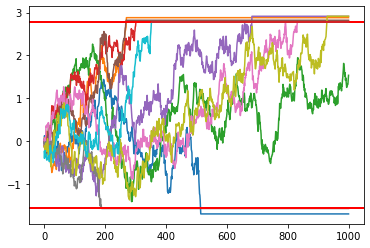

In [5]:
n_total = np.array([])
decision = np.array([])
for i in range(10):
    n, d = SLRT()
    n_total = np.append(n_total,n)
    decision =  np.append(decision, d)

In [127]:
np.nanmean(decision) ## power

0.7708333333333334

In [128]:
np.mean(n_total)

391.25

## Sample with weights

In [129]:
import numpy as np

In [152]:
rng = np.random.RandomState(0)
weight = np.array([1,2,3,4,5])
samples = rng.choice(5,p=weight/sum(weight),size=1000) ## In R, you don't have to normalize

In [153]:
import collections
summary = collections.Counter(samples)

In [156]:
dict(sorted(summary.items(), key = lambda x: x[0]))

{0: 66, 1: 134, 2: 215, 3: 254, 4: 331}

In [25]:
temp = [[]]
len(temp)

1

In [24]:
if temp:
    print(8)

8


In [27]:
ord("5") - ord('0')

5

## Extreme value (fat tail)

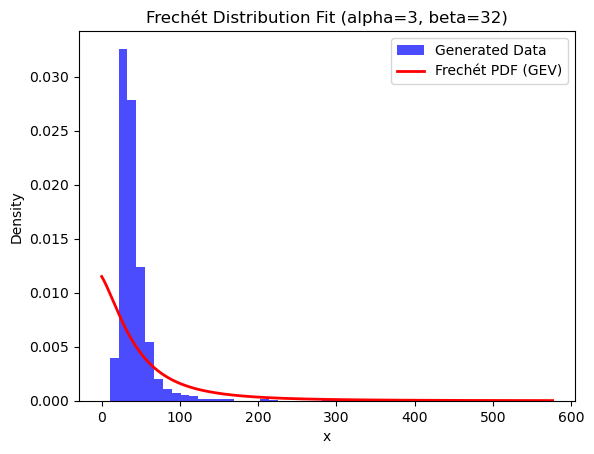

In [20]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Parameters
N = 1000  # Number of random variables
degrees_of_freedom = 3  # Degrees of freedom for Student's t-distribution

# Step 1: Generate N random variables from a Student's t-distribution
student_t_rvs = stats.t.rvs(df=degrees_of_freedom, size=N)

# Step 2: Transform these variables to approximate a Frechét distribution
# Frechét parameters from the image: alpha = 3, beta = 32
alpha = 3
beta = 32

# Transform the t-distributed variables into Frechét-distributed variables
frechet_rvs = beta * (np.abs(student_t_rvs)) ** (-1 / alpha)

# Step 3: Plot the histogram of the generated data
plt.hist(frechet_rvs, bins=50, density=True, alpha=0.7, color='b', label="Generated Data")

# Step 4: Plot the actual Frechét distribution for comparison using the Generalized Extreme Value (GEV) distribution
# The Frechét distribution is a GEV with shape parameter c = -1/alpha
c = -1 / alpha  # Frechét shape parameter
x = np.linspace(0, np.max(frechet_rvs), 1000)
frechet_pdf = stats.genextreme.pdf(x, c=c, scale=beta)
plt.plot(x, frechet_pdf, 'r-', lw=2, label='Frechét PDF (GEV)')

# Labels and title
plt.title('Frechét Distribution Fit (alpha=3, beta=32)')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()


In [24]:
max(frechet_rvs)

576.5302807276903

## Scale-invariance of power distribution

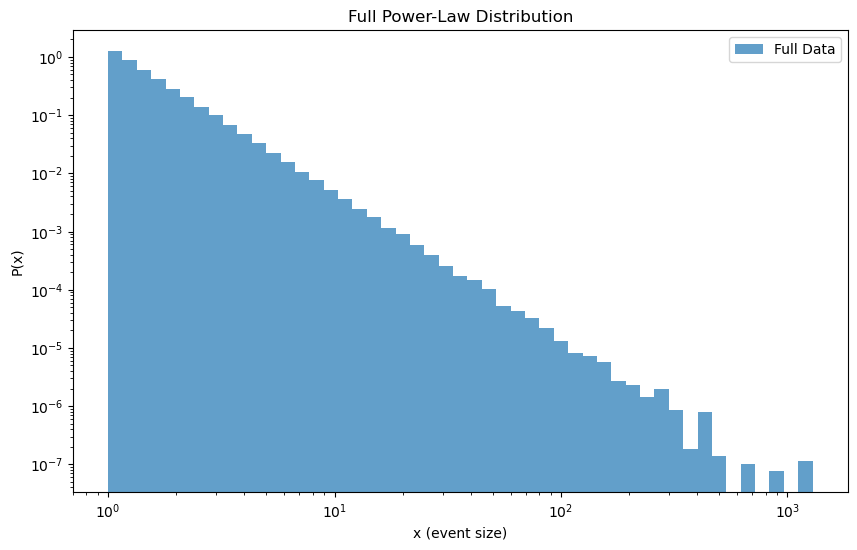

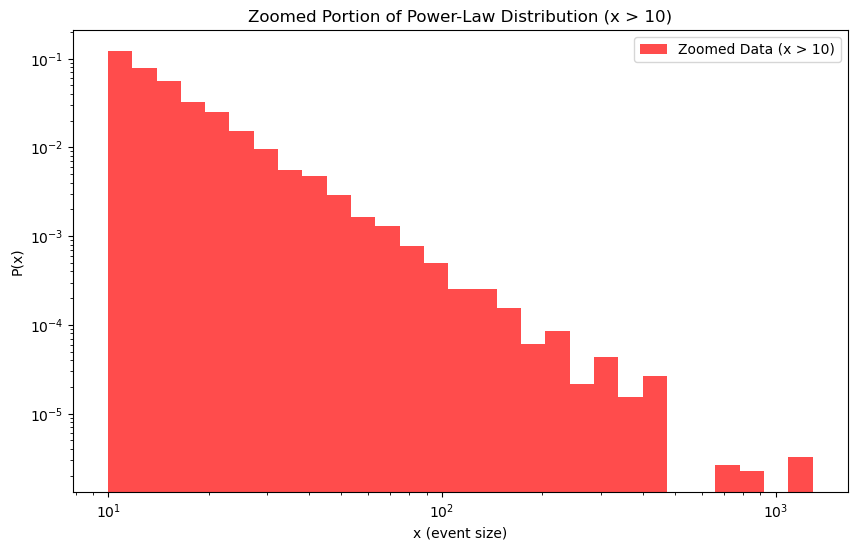

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the power-law distribution
alpha = 2.5  # Tail exponent
x_min = 1
N = 100000  # Number of data points

# Step 1: Generate random variables following a power-law distribution
# Using inverse transform sampling for a power-law distribution
r = np.random.uniform(0, 1, N)
power_law_data = x_min * (1 - r) ** (-1 / (alpha - 1))

# Step 2: Plot the full power-law distribution (log-log plot for clarity)
plt.figure(figsize=(10, 6))
plt.hist(power_law_data, bins=np.logspace(np.log10(x_min), np.log10(np.max(power_law_data)), 50), density=True, alpha=0.7, label='Full Data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('x (event size)')
plt.ylabel('P(x)')
plt.title('Full Power-Law Distribution')
plt.legend()

# Step 3: Zoom in on a smaller portion of the distribution (e.g., events with x > 10)
zoom_factor = 10  # Zoom in on events larger than 10
zoomed_data = power_law_data[power_law_data > zoom_factor]

plt.figure(figsize=(10, 6))
plt.hist(zoomed_data, bins=np.logspace(np.log10(zoom_factor), np.log10(np.max(zoomed_data)), 30), density=True, alpha=0.7, color='r', label=f'Zoomed Data (x > {zoom_factor})')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('x (event size)')
plt.ylabel('P(x)')
plt.title(f'Zoomed Portion of Power-Law Distribution (x > {zoom_factor})')
plt.legend()

plt.show()


### Efficiancy of median and mean

In [7]:
rng = np.random.RandomState(seed=8888)

In [31]:
def sample_gumbel(loc=0, scale=1, size=1000, func=None):
    """
    Generate samples from a Gumbel distribution and optionally apply a function.
    
    Parameters:
    - loc: location parameter (default 0)
    - scale: scale parameter (default 1)
    - size: number of samples to generate
    - func: function to apply to the samples (default None)
    
    Returns:
    - If func is None: Array of samples from the Gumbel distribution
    - If func is provided: Result of applying func to the samples
    """
    u = np.random.uniform(0, 1, size=size)
    samples = loc - scale * np.log(-np.log(u))
    
    if func is not None:
        return func(samples)
    else:
        return samples

In [ ]:
def sample_frechet():
    # Parameters
    N = 1000  # Number of random variables
    degrees_of_freedom = 3  # Degrees of freedom for Student's t-distribution
    
    # Step 1: Generate N random variables from a Student's t-distribution
    student_t_rvs = stats.t.rvs(df=degrees_of_freedom, size=N)
    
    # Step 2: Transform these variables to approximate a Frechét distribution
    # Frechét parameters from the image: alpha = 3, beta = 32
    alpha = 3
    beta = 32
    
    # Transform the t-distributed variables into Frechét-distributed variables
    frechet_rvs = beta * (np.abs(student_t_rvs)) ** (-1 / alpha)

In [61]:
median_vec = Parallel(n_jobs=10)(delayed(sample_gumbel)(scale = 20, func=np.median) for _ in range(10000))
mean_vec = Parallel(n_jobs=10)(delayed(sample_gumbel)(scale = 20, func=np.mean) for _ in range(10000))

In [62]:
np.var(mean_vec) > np.var(median_vec)

False

In [65]:
np.var(mean_vec),np.var(median_vec)

(0.6587389712331541, 0.8231056315773402)

## Median by hand

In [108]:
x = rng.normal(size=100)
x = np.sort(x)

In [110]:
def temp_median(x):
    n = len(x)
    idx = n // 2
    if n % 2 == 0:
        return ((x[idx] + x[idx-1])/2)
    else:
        return x[idx]

In [112]:
temp_median(x) == np.median(x)

True

## Truncated normal 1
1.	You have random number X ~ N(mu, sigma^2), where mu and sigma^2 are unknown. You don't observe X, but observe Y, where Y=X if X<= 10; X>10 then Y unknown. How do you estimate mu and sigma^2?

In [523]:
X_size = 10000
X = rng.normal(size=X_size, loc = 9, scale = 4)
Y = np.where(X <= 10, X, np.nan)
Y_non_nan = Y[~np.isnan(Y)]

In [355]:
import matplotlib.pyplot as plt

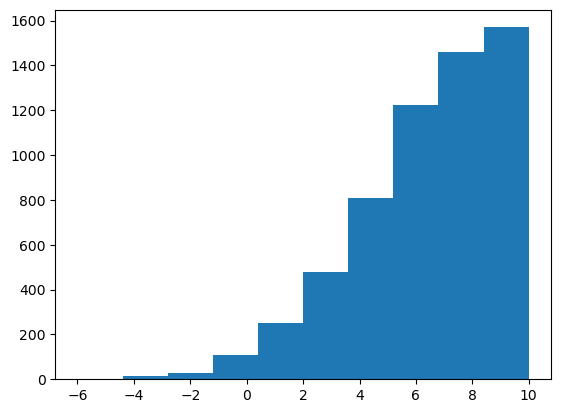

In [357]:
plt.hist(Y_non_nan);

In [359]:
# Define bin edges with size 0.1
bin_size = 0.2
bin_edges = np.arange(np.min(Y_non_nan)-0.1, np.max(Y_non_nan), bin_size)

# Use np.histogram to count the number of data points in each bin
counts, _ = np.histogram(Y_non_nan, bins=bin_edges)

# Convert bin edges and counts into a dictionary for easy access
bin_counts = {f'{bin_edges[i]} - {bin_edges[i+1]}': counts[i] for i in range(len(counts))}


In [389]:
len(counts), len(bin_edges)

(80, 81)

In [361]:
max_key = max(bin_counts.values())

In [363]:
[(bin, value) for bin, value in bin_counts.items() if value == max_key]

[('8.709796258908126 - 8.909796258908127', 223)]

In [371]:
Y_non_nan_norm = Y_non_nan - 9

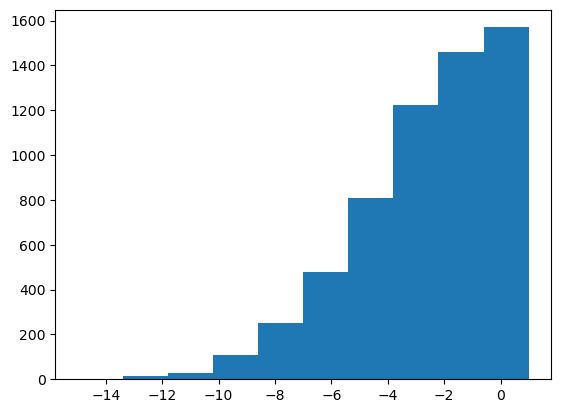

In [373]:
plt.hist(Y_non_nan_norm);

In [375]:
np.std(np.concatenate((Y_non_nan_norm[Y_non_nan_norm<=0],np.abs(Y_non_nan_norm[Y_non_nan_norm<=0]))))

3.9966757274072453

In [423]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

# Generate synthetic observed data for X <= 10
np.random.seed(42)
data = np.random.normal(loc=9, scale=4, size=10000)  # Normal distribution with mean=5, std=2
observed_data = data[data <= 10]  # Only keep data where X <= 10
censored_count = len(data[data > 10])  # Number of censored data points

def log_likelihood(params, observed_data, censored_count):
    mu, log_sigma = params  # log_sigma is unconstrained
    sigma = np.exp(log_sigma)  # Transform to ensure sigma > 0
    # Log-likelihood for observed data (X <= 10)
    observed_ll = np.sum(norm.logpdf(observed_data, loc=mu, scale=sigma))
    # Log-likelihood for censored data (X > 10)
    censored_ll = censored_count * np.log(1 - norm.cdf(10, loc=mu, scale=sigma))
    # Add Jacobian for the transformation of sigma = exp(log_sigma)
    return -(observed_ll + censored_ll - log_sigma)  # Include Jacobian (log_sigma)

# Initial guesses for mu and log_sigma
initial_params = [5, np.log(2)]  # Start with log_sigma instead of sigma

# Perform optimization without bounds since sigma is transformed to be positive
result = minimize(log_likelihood, initial_params, args=(observed_data, censored_count))

mu_hat, log_sigma_hat = result.x
sigma_hat = np.exp(log_sigma_hat)
print(f"Estimated mu: {mu_hat}")
print(f"Estimated sigma: {sigma_hat}")


Estimated mu: 8.98943114023069
Estimated sigma: 4.008274410964045


## Truncated normal 2

假设现在有一个normal distribution with mean unknown，sd 1. 随机从这个distribution里面抽sample直到抽到的数字大于1，用这个数字和1.96进行比较，如果大于1.96就reject null hypothesis that the mean of the normal distribution is 1。要求用simulation来算type 1 error。

In [798]:
from scipy.stats import truncnorm, norm

### Standardized Bound Formulas for Truncated Normal Distribution:

For a truncated normal distribution with mean $ \mu $ and standard deviation $ \sigma $, the standardized bounds are given by:

$$
a = \frac{\text{lower bound} - \mu}{\sigma}
$$

$$
b = \frac{\text{upper bound} - \mu}{\sigma}
$$

Where:
- $ a $ is the standardized lower bound.
- $ b $ is the standardized upper bound.
- $ \mu $ is the mean of the truncated normal distribution.
- $ \sigma$ is the standard deviation (scale) of the distribution.


In [913]:
x = truncnorm.rvs(size=1000000,a=0,b=np.inf,loc=1,scale=1)

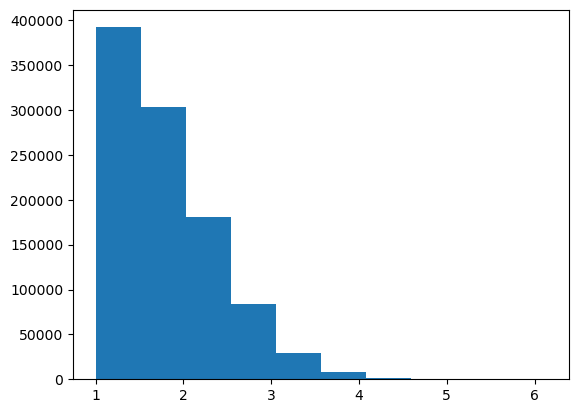

In [915]:
plt.hist(x);

In [917]:
sum(x>=1.96)/len(x)

0.336663

In [919]:
x_norm = norm.rvs(size=1000000,loc=1,scale=1)
x_trunc_norm = x_norm[x_norm>1]

In [921]:
sum(x_trunc_norm>=1.96)/len(x_trunc_norm)

0.33687528842062364

In [833]:
p_value = (1-norm.cdf(1.96, loc = 1)) / (1-norm.cdf(1, loc = 1))
p_value

0.33705521493367563

In [835]:
# more accurate than above
norm.sf(1.96, loc = 1)/ norm.sf(1, loc = 1)

0.33705521493367563

In [837]:
# most accurate
np.exp(norm.logsf(1.96, loc = 1)-norm.logsf(1, loc = 1))

0.3370552149336757

4.	Now, suppose that we employ the 1st option. Suppose that now the response is binary (better/worse), and we have 60 out of 100 subjects taking Drug A who felt better, and 70 out of 120 taking Drug B who felt better. How do you tell which drug is more effective?

In [449]:
from scipy.stats import binom, norm

__binomial test__

In [443]:
## p_value
1-binom.cdf(69, n=120,p=0.6)

0.6809906480947429

__using the pooled test__

In [459]:
p1 = 60/100
p2 = 70/120
p_pool = 130/220
pq = p_pool * (1-p_pool)
sd = np.sqrt(pq/100 + pq/120)
z = (p1 - p2) / sd
(1-norm.cdf(z))

0.40115607605930637

__using the more conservative un-pooled test__

In [467]:
sd = np.sqrt(p1*(1-p1)/100 + p2*(1-p2)/120)
z = (p1 - p2) / sd
(1-norm.cdf(z))

0.40108660023967624

In [493]:
table = [[60, 40], [70, 50]]  # Example counts for Drug A and Drug B

# Perform Fisher's exact test
odds_ratio, p_value = stats.fisher_exact(table)
odds_ratio, p_value

(1.0714285714285714, 0.8905700679510844)

In [495]:
# Create a contingency table for Drug A and Drug B outcomes
# Drug A: 60 better out of 100
# Drug B: 70 better out of 120

observed = np.array([[60, 40], [70, 50]])  # [Better, Not Better] for Drug A and Drug B

# Perform the chi-squared test of independence
chi2_stat, chi2_p_value, dof, expected = stats.chi2_contingency(observed)

chi2_stat, chi2_p_value, expected


(0.01269230769230753,
 0.910300001739743,
 array([[59.09090909, 40.90909091],
        [70.90909091, 49.09090909]]))

## QQ plot

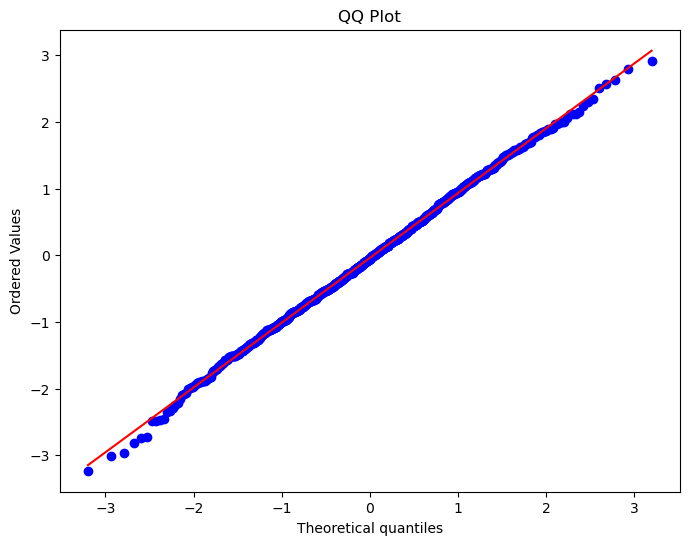

In [470]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Generate some sample data
data = np.random.normal(0, 1, 1000)

# Create QQ plot
fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(data, dist="norm", plot=ax)
ax.set_title("QQ Plot")
plt.show()

## KS and Anderson-Darling test

In [475]:
from scipy.stats import kstest, norm, anderson

# Generate a random sample from a normal distribution
data = norm.rvs(size=100, loc=0, scale=1)

# Perform the KS test for normality
ks_stat, p_value = kstest(data, 'norm')
ks_stat, p_value

(0.07131002177386914, 0.6625690639030705)

In [477]:
result = anderson(data, dist='norm')

print('Anderson-Darling Statistic:', result.statistic)
print('Critical Values:', result.critical_values)
print('Significance Levels:', result.significance_level)

Anderson-Darling Statistic: 0.4007380493655148
Critical Values: [0.555 0.632 0.759 0.885 1.053]
Significance Levels: [15.  10.   5.   2.5  1. ]


# Sampling

## rejection sampling

using laplace distribution to sample normal

In [598]:
from scipy.stats import laplace

In [721]:
scale = 1
x = laplace.rvs(size= 100000,scale = scale, loc=0)

In [723]:
M = np.sqrt(2/len(x)) * scale * np.exp(1/(2*scale**2))
M

0.007373305674470638

In [725]:
r = np.random.uniform(size = len(x))

In [741]:
p_mask = r < norm.pdf(x) / (M * laplace.pdf(x, scale=scale, loc=0))

In [743]:
sum(p_mask)

98821

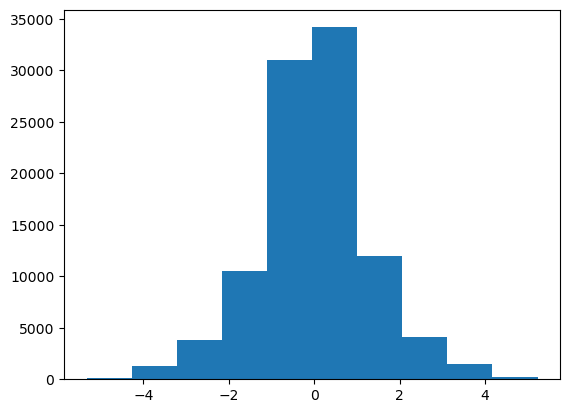

In [745]:
plt.hist(x[p_mask]);

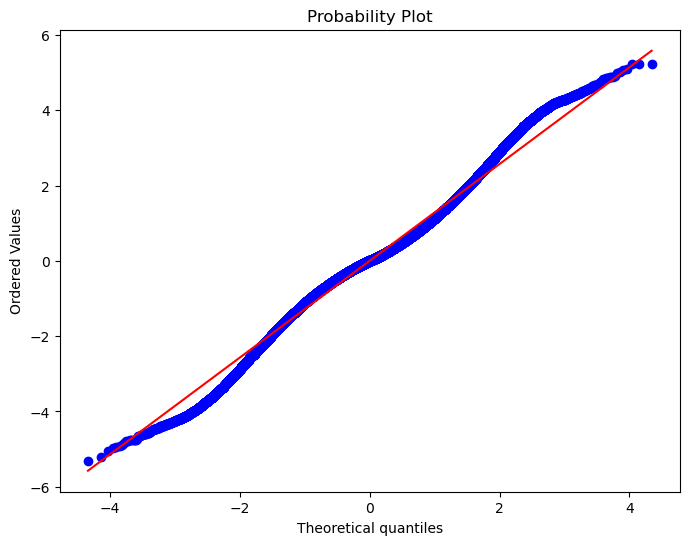

In [747]:
fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(x[p_mask],dist="norm",plot=ax);

In [734]:
kstest(x[p_mask], 'norm')

KstestResult(statistic=0.04280952007921701, pvalue=9.234348350644197e-158, statistic_location=1.7601516724130493, statistic_sign=-1)

In [681]:
anderson(x[p_mask], dist='norm')

AndersonResult(statistic=565.094334870606, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.00044832975930020276, scale=1.2845844660059527)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

## Importance sampling

In [739]:
## Sampling from Laplace proposal distribution
scale = 1
x = laplace.rvs(size= 100000,scale = scale, loc=0)

In [755]:
## Obtaining importance sampling weights and normalize it
weight = norm.pdf(x)/laplace.pdf(x,scale=scale, loc=0)
weight_norm = weight/sum(weight)

In [765]:
## Resample based on weigths
ip_samples = np.random.choice(x,p=weight_norm,replace=False, size = 1000)

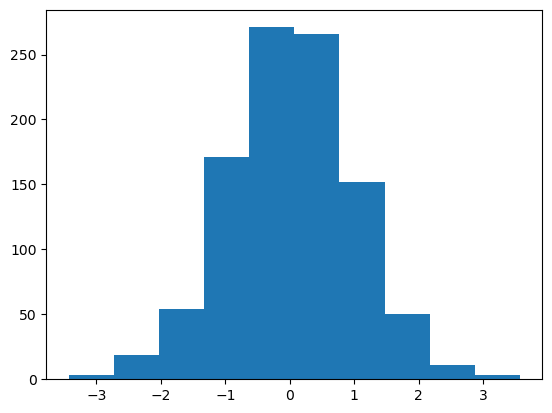

In [767]:
plt.hist(ip_samples);

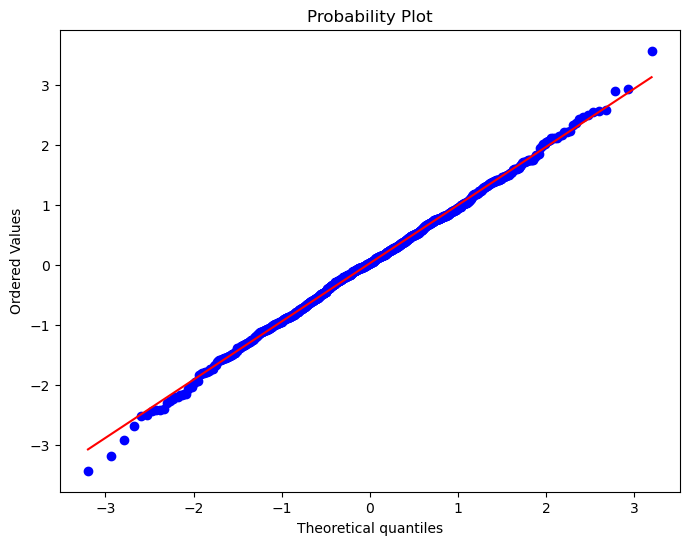

In [773]:
fig, ax = plt.subplots(figsize=(8,6))
stats.probplot(ip_samples, plot=ax, dist='norm');

In [779]:
kstest(ip_samples, 'norm')

KstestResult(statistic=0.03782125688895843, pvalue=0.11153509503632875, statistic_location=-0.2902270887955193, statistic_sign=-1)

In [781]:
anderson(ip_samples,'norm')

AndersonResult(statistic=0.3709730508069242, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.029647286461092142, scale=0.9685918409754403)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')